In [ ]:
#from shrink_dataset import extract_datasets
#extract_datasets()

In [2]:
import wandb
from evaluate_task import Task
GPT3_5 = "gpt-3.5-turbo-0125"
GPT4 = "gpt-4-0125-preview"

anachronism = Task('multiple_choice',
                   'datasets/task_anachronisms.json',
                   'Does the following sentence contain non-contemporaneous (anachronistic) elements?.')
logical_sequence = Task('multiple_choice',
                        'datasets/task_logical_sequence.json',
                        "Identify the correct chronological or sequential order of items in a list.")
color_HCL = Task('multiple_choice', 'datasets/task_color_HCL.json',"")
color_RGB = Task('multiple_choice', 'datasets/task_color_RGB.json',"")
color_HEX = Task('multiple_choice', 'datasets/task_color_HEX.json',"")
color_HSL = Task('multiple_choice', 'datasets/task_color_HSL.json',"")
matrixshapes = Task('free_response',
                    'datasets/task_matrixshapes.json',
                    "Compute the final matrix shape after the given operations are performed.")
operators = Task('free_response',
                    'datasets/task_operators.json',
                    "Given the definition of the op operator, compute the result.")


In [ ]:
#BASELINE

MULTIPLE_CHOICE_SUFFIX = "Just repeat the answer you choose."
FREE_RESPONSE_SUFFIX = "Please don't show me the steps, i just want to see the final result in one single line."

In [ ]:
#WITH EXPLANATION

MULTIPLE_CHOICE_SUFFIX = "First you explain your answer in 50 words, in the last line you answer just repeating the answer you choose."
FREE_RESPONSE_SUFFIX = "First you explain your answer in 50 words, in the last line you answer just the result."


In [ ]:
#CHAIN OF THOUGHTS

MULTIPLE_CHOICE_SUFFIX = "Split the problem in steps, resolve the steps and then in the last line you just repeat the answer you choose."
FREE_RESPONSE_SUFFIX = "Split the problem in steps, resolve the steps and then in the last line answer just the result."

In [ ]:
#FEW-SHOTS

#starting from the baseline suffixes
MULTIPLE_CHOICE_SUFFIX = "Just repeat the answer you choose."
FREE_RESPONSE_SUFFIX = "Please don't show me the steps, i just want to see the final result in one single line."

for task in [anachronism, logical_sequence, color_HCL, color_RGB, color_HEX, color_HSL, matrixshapes, operators]:

    wandb.init(project="LLMs-Still-Can-t",config={"model": GPT4,"shots": 5})

    suffix = MULTIPLE_CHOICE_SUFFIX if task.type == 'multiple_choice' else FREE_RESPONSE_SUFFIX
    acc , df = task.evaluate(wandb.config.model, suffix, wandb.config.shots)

    wandb.log({ "accuracy": acc, "examples": wandb.Table(dataframe=df)})

    wandb.run.summary["system_prompt"] = task.system_prompt + suffix
    wandb.run.summary["model"] = wandb.config.model
    wandb.run.summary["shots"] = wandb.config.shots
    wandb.run.summary["name"] = f"Baseline [{task.json_string}]"

    wandb.finish()


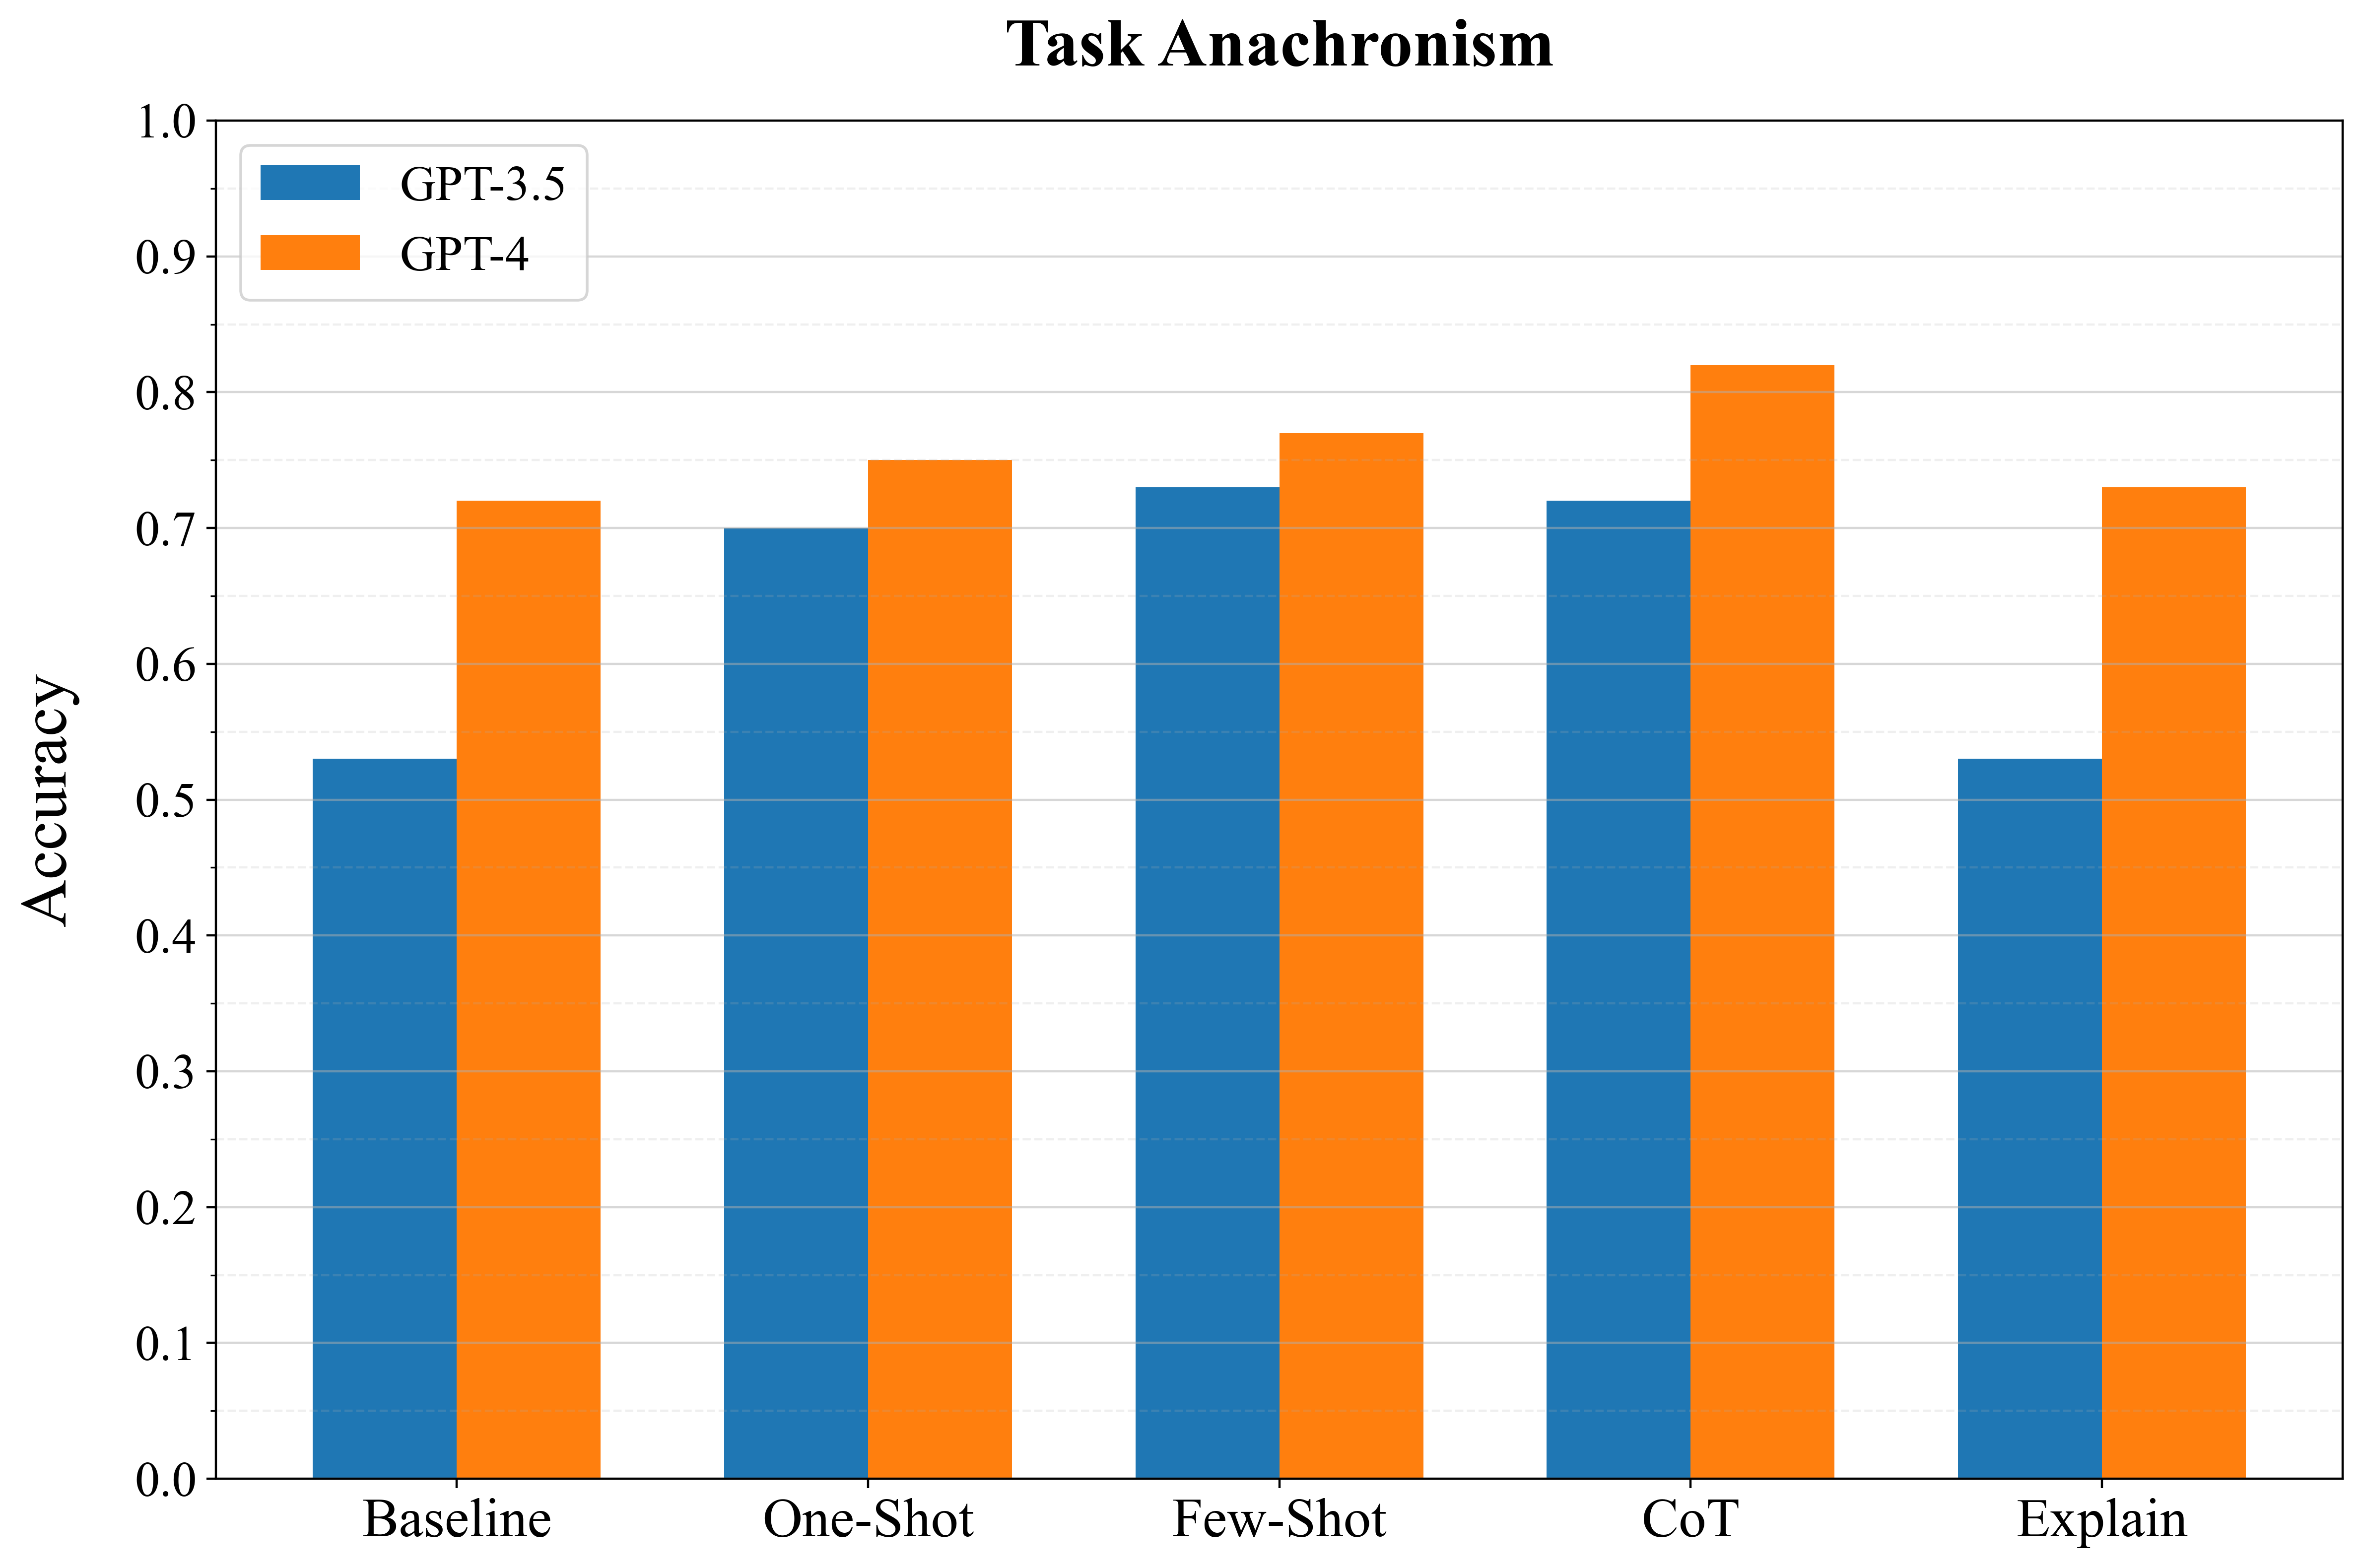

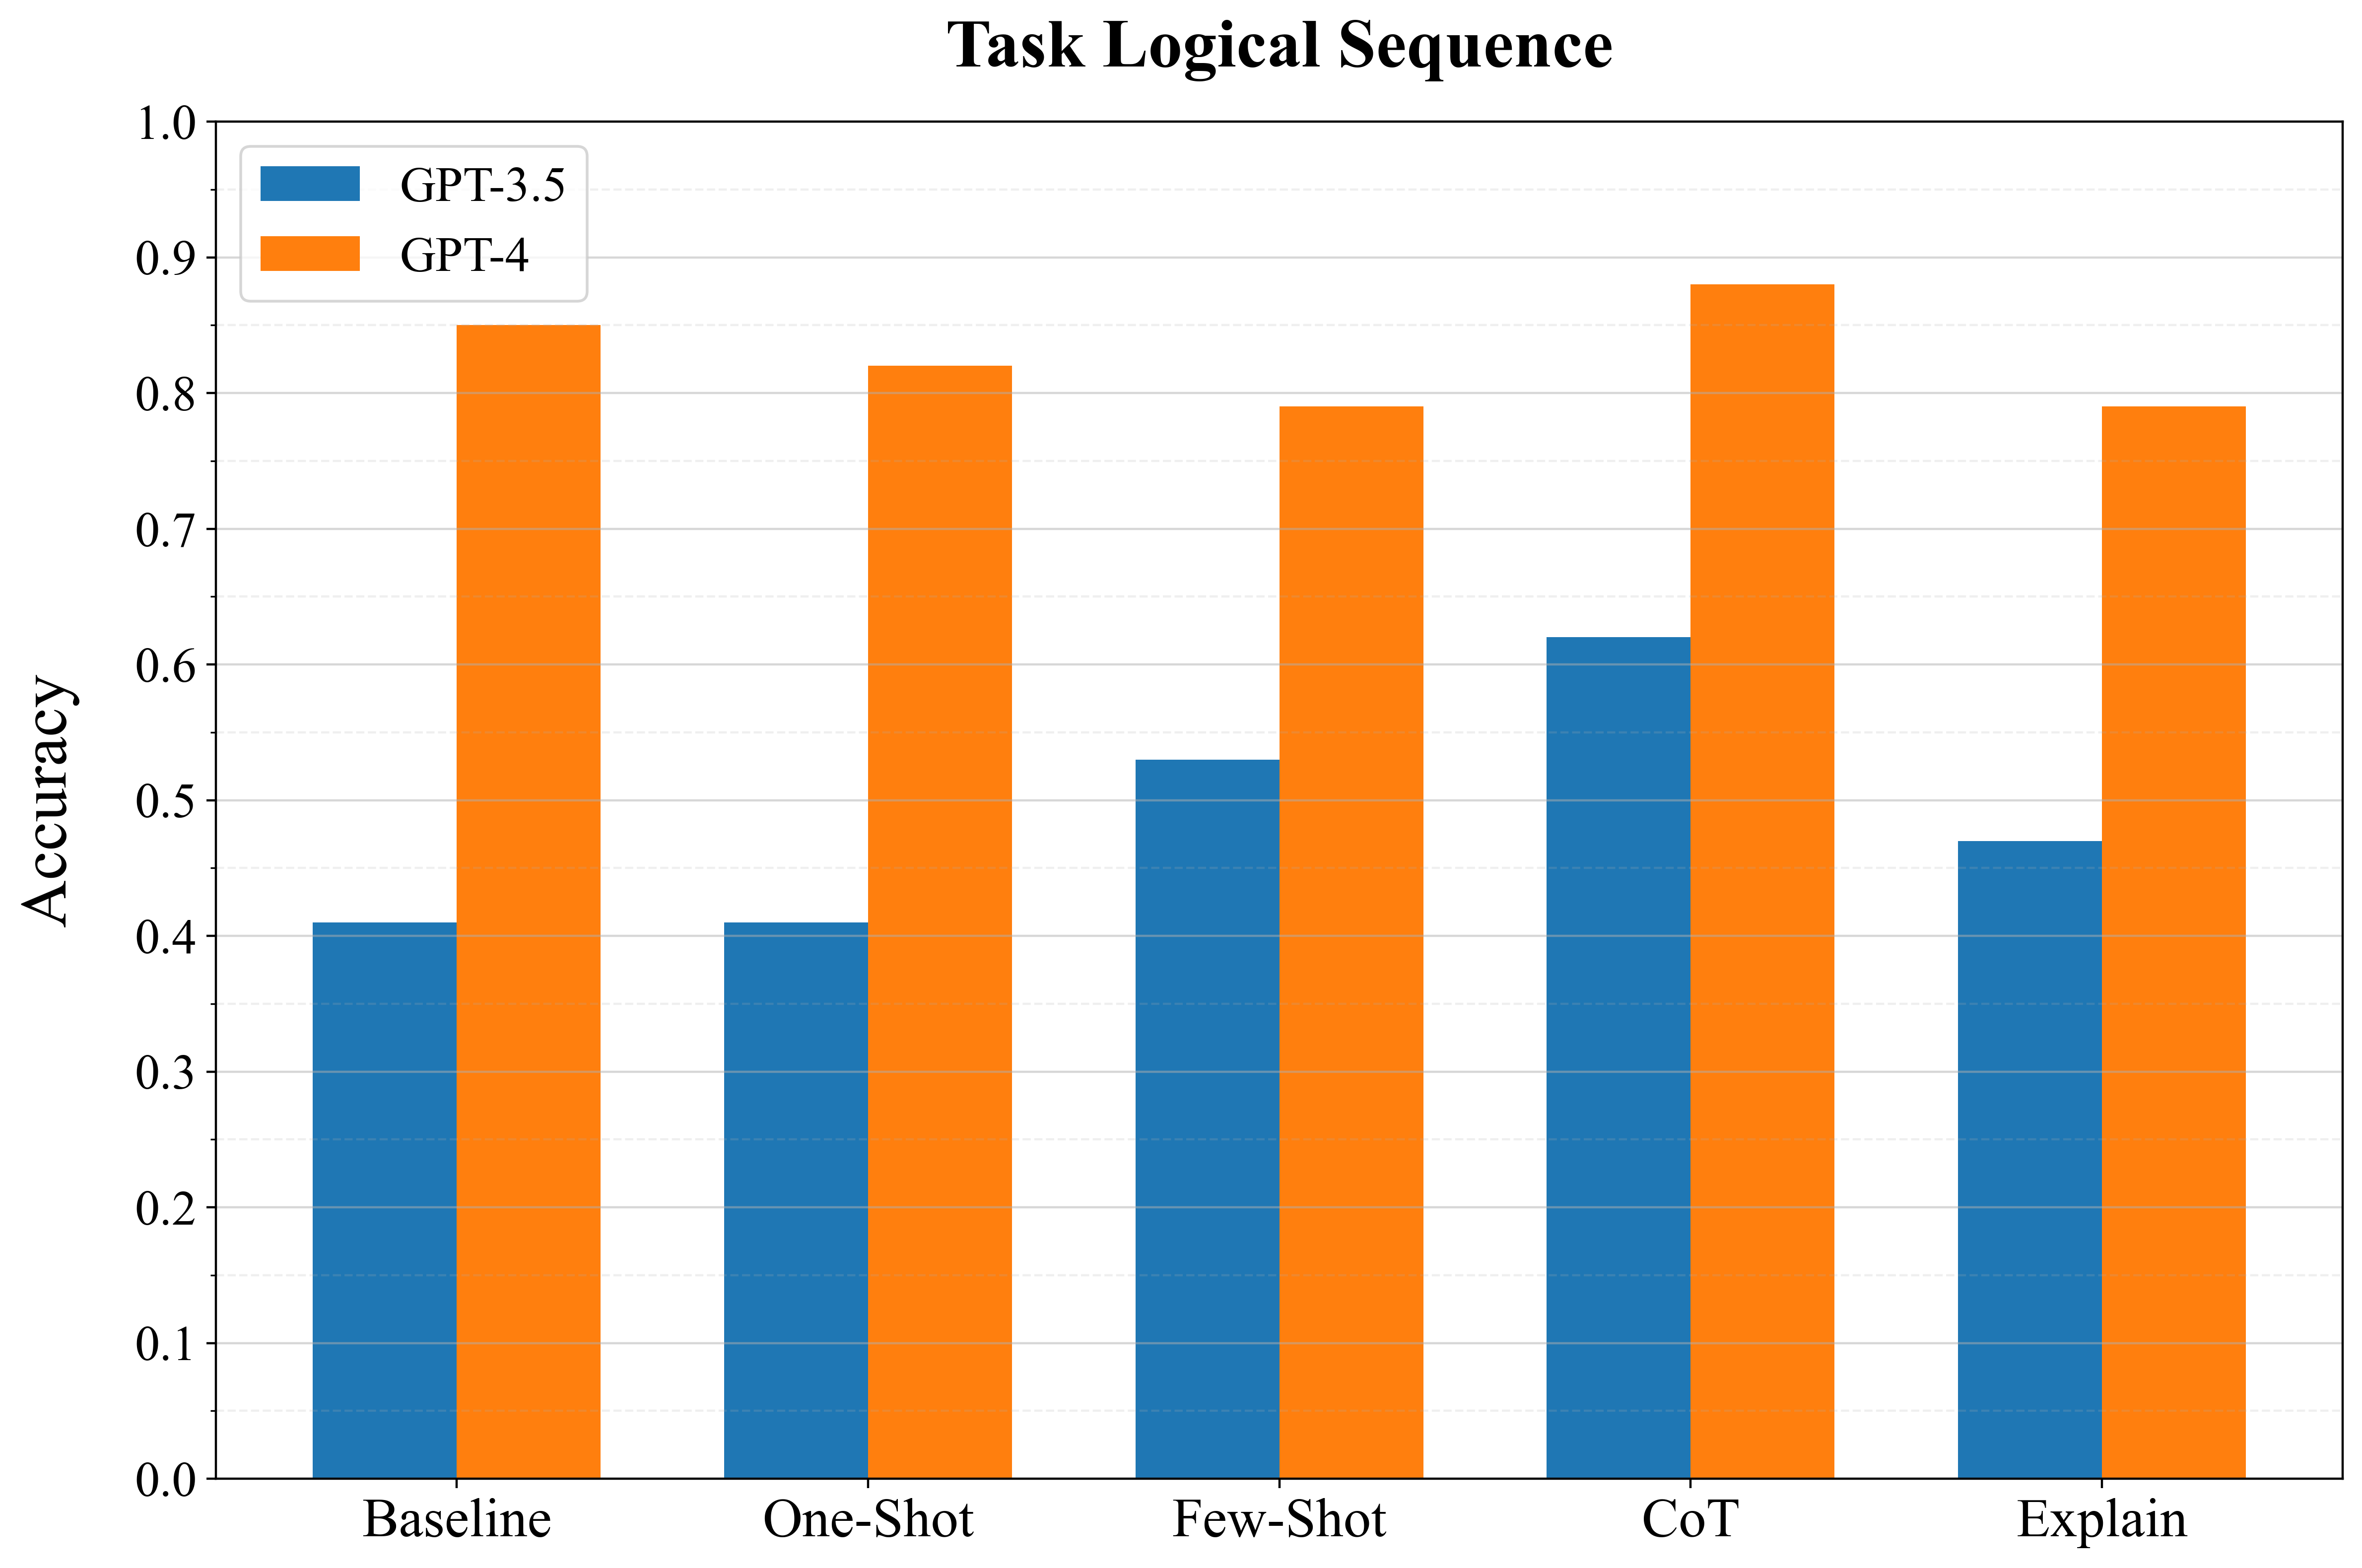

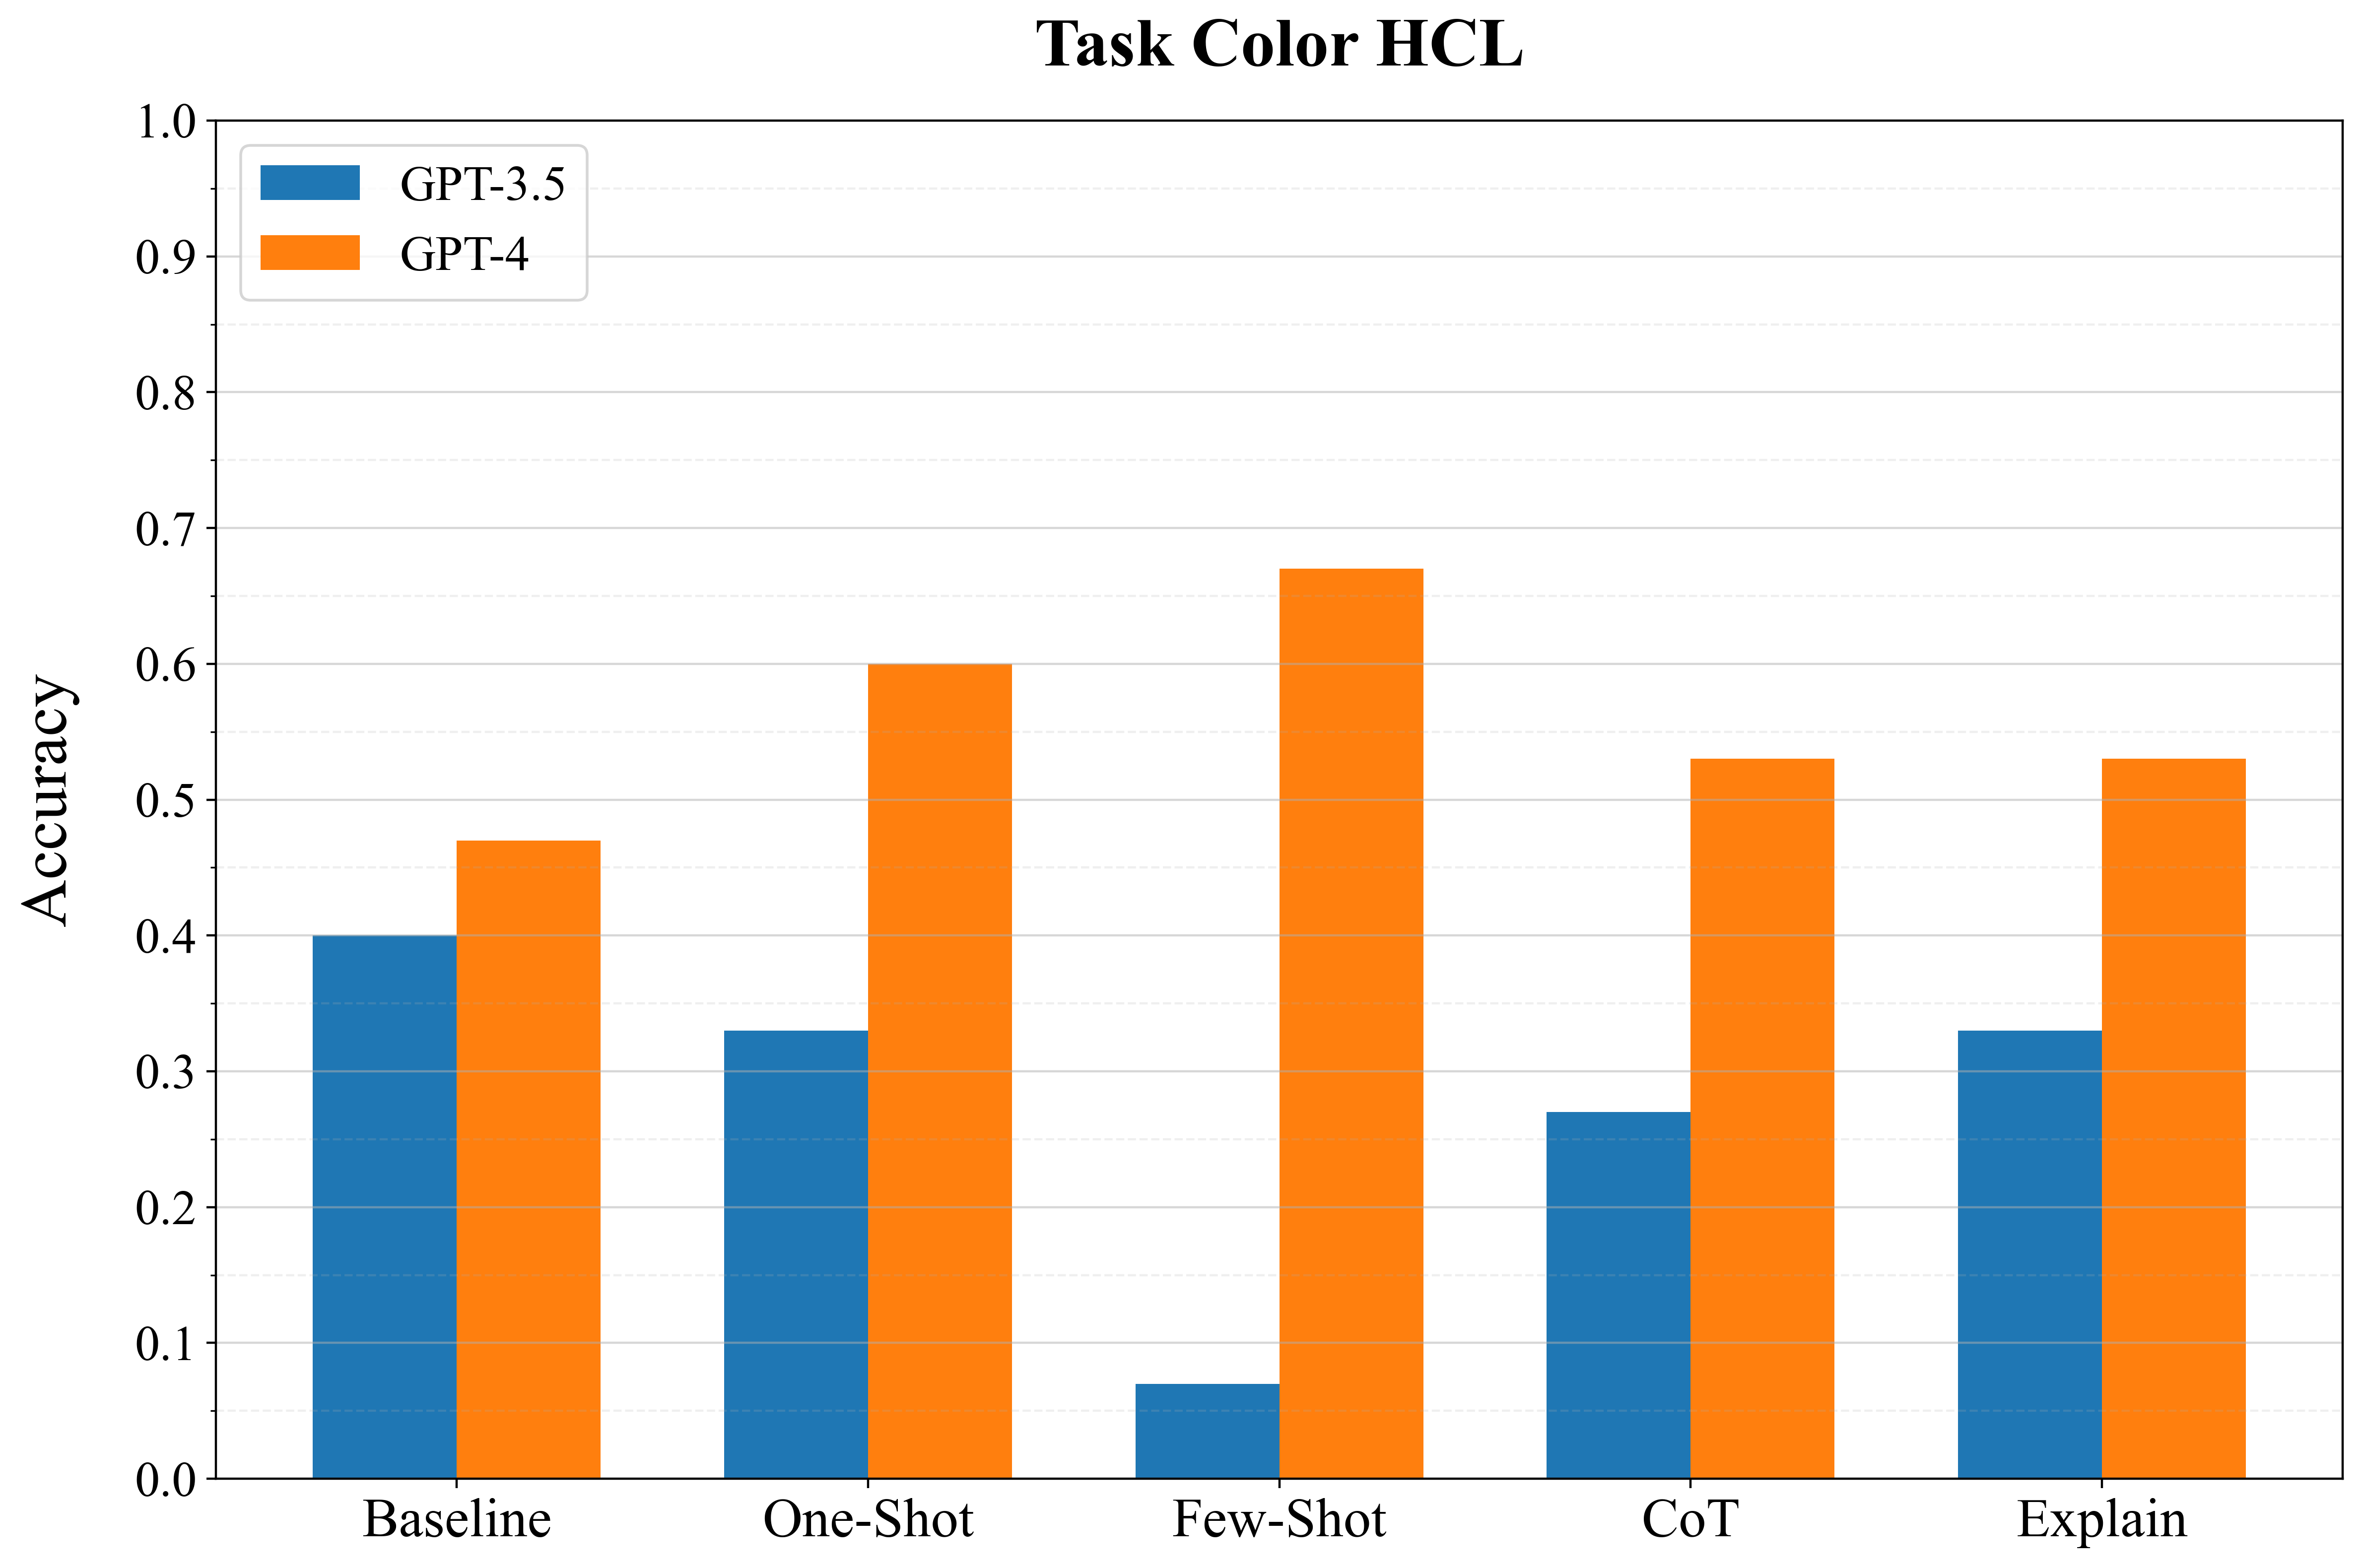

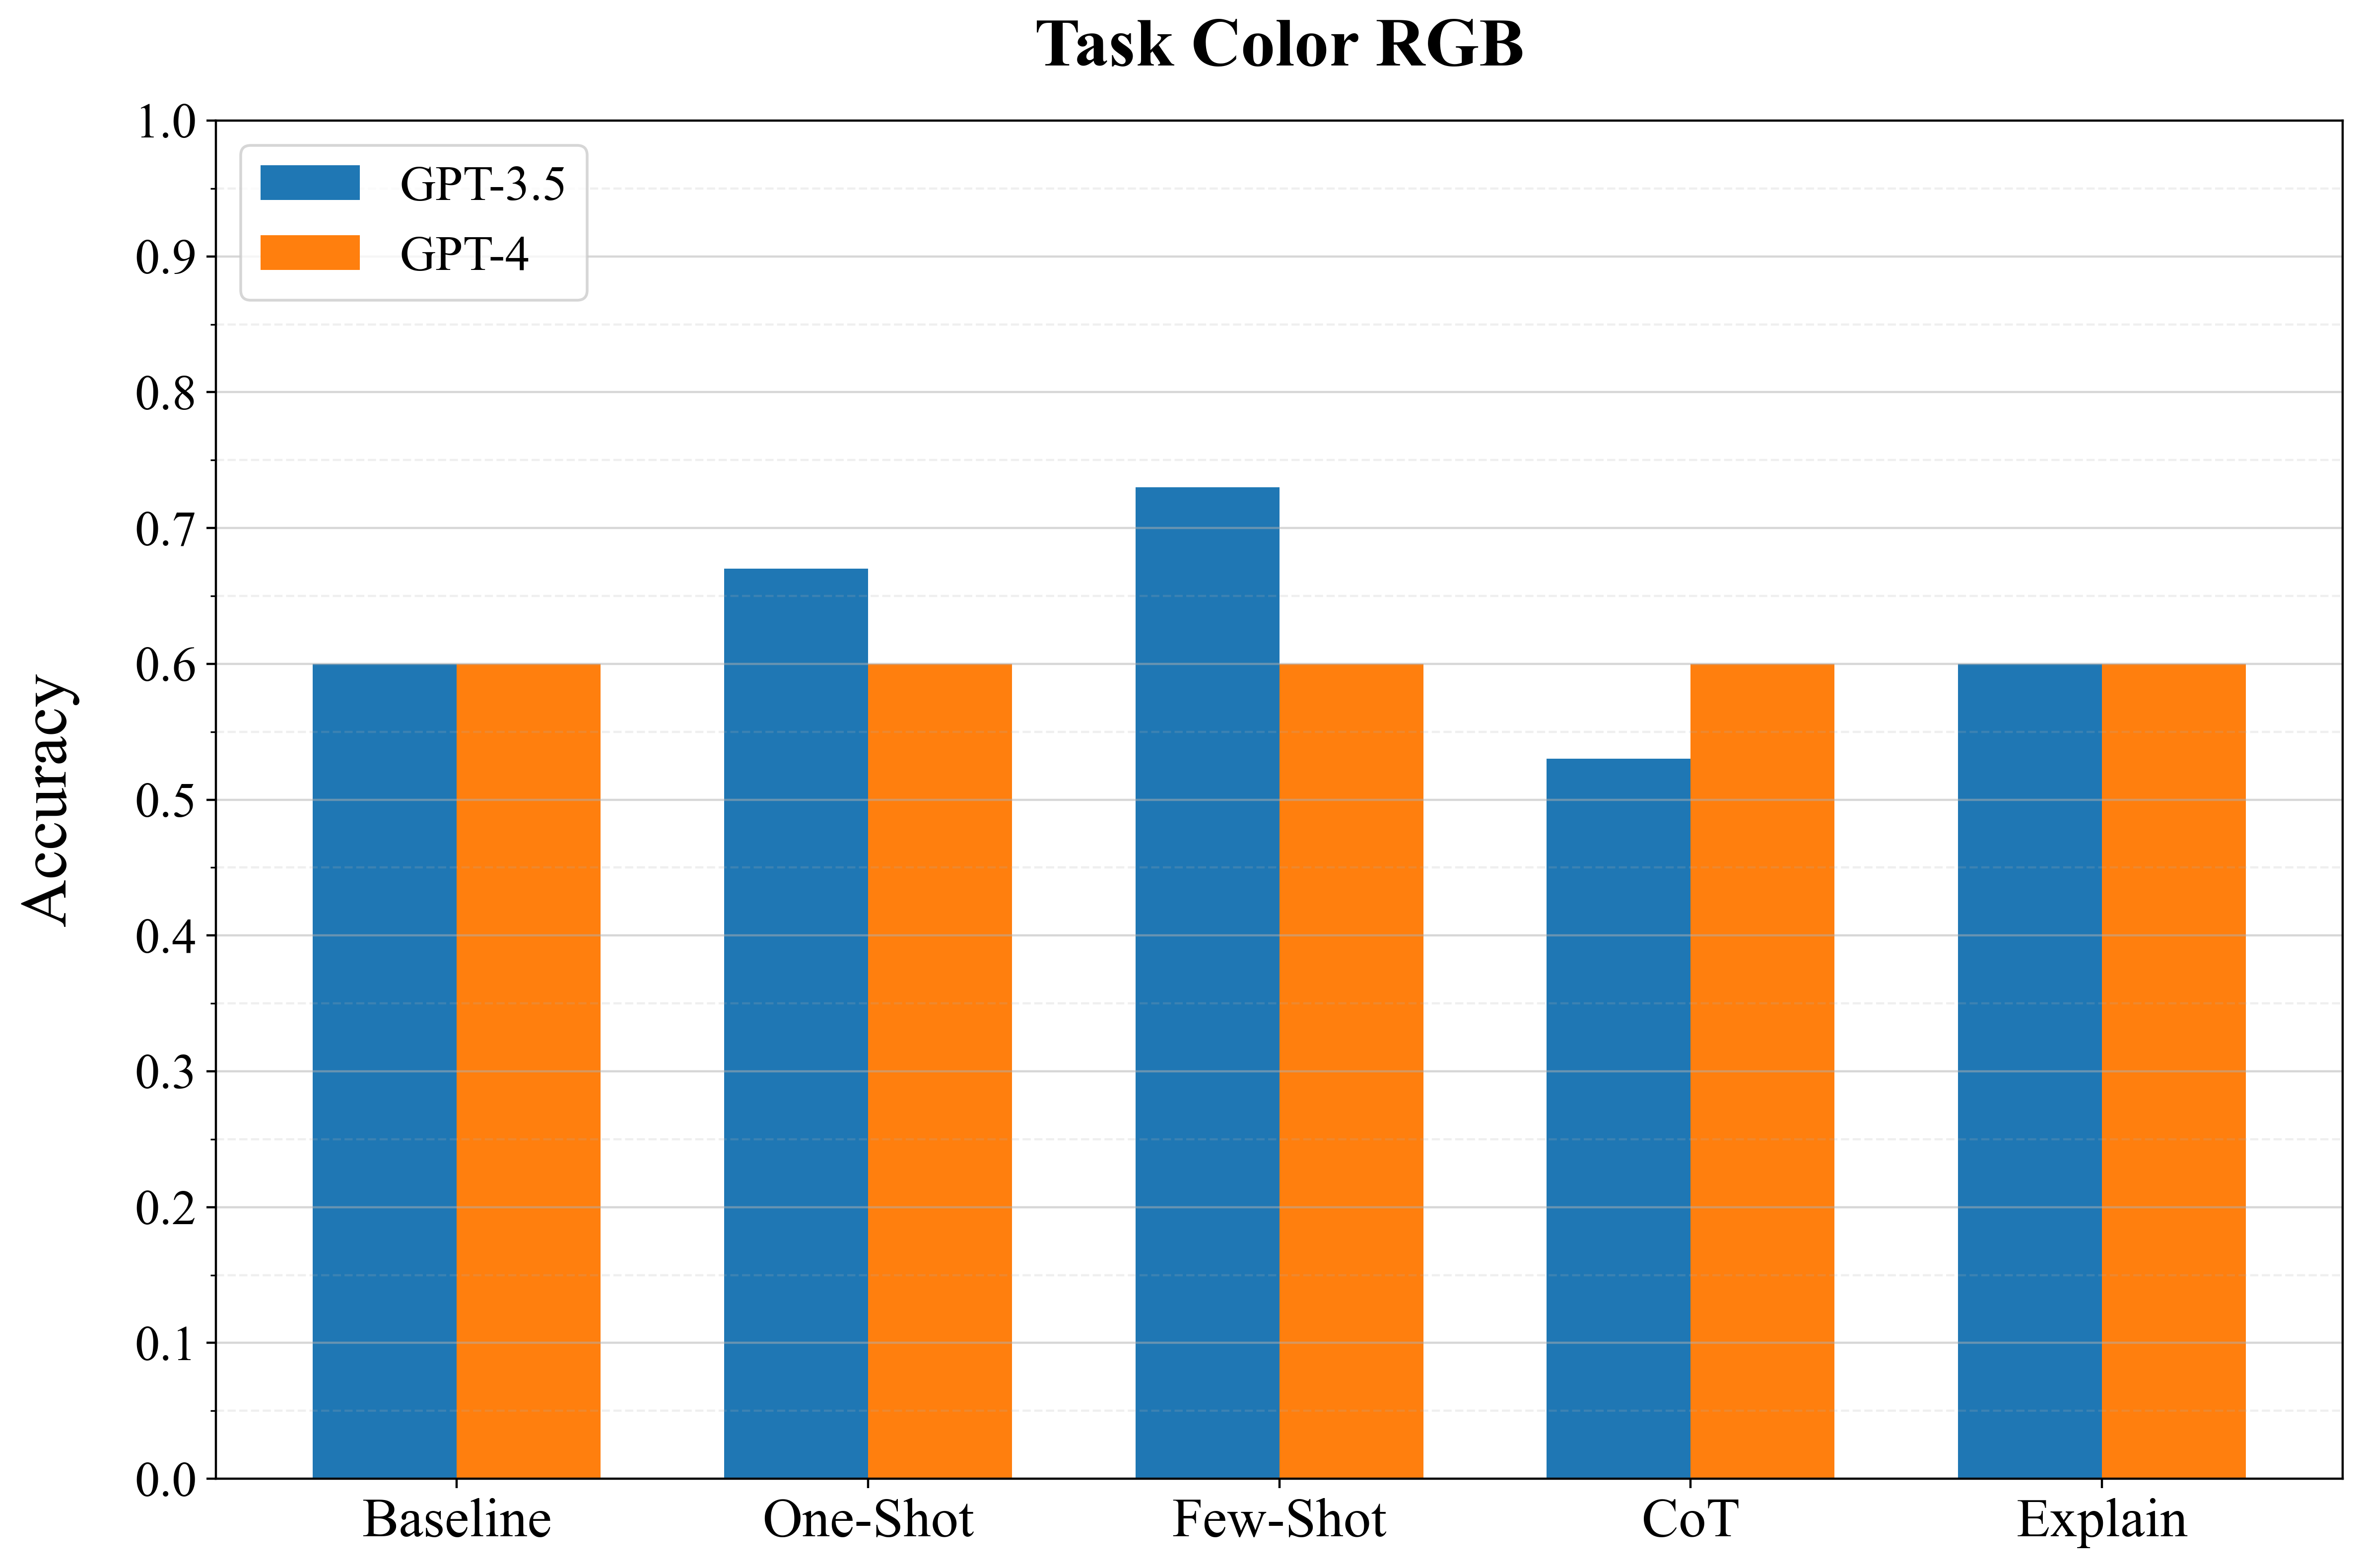

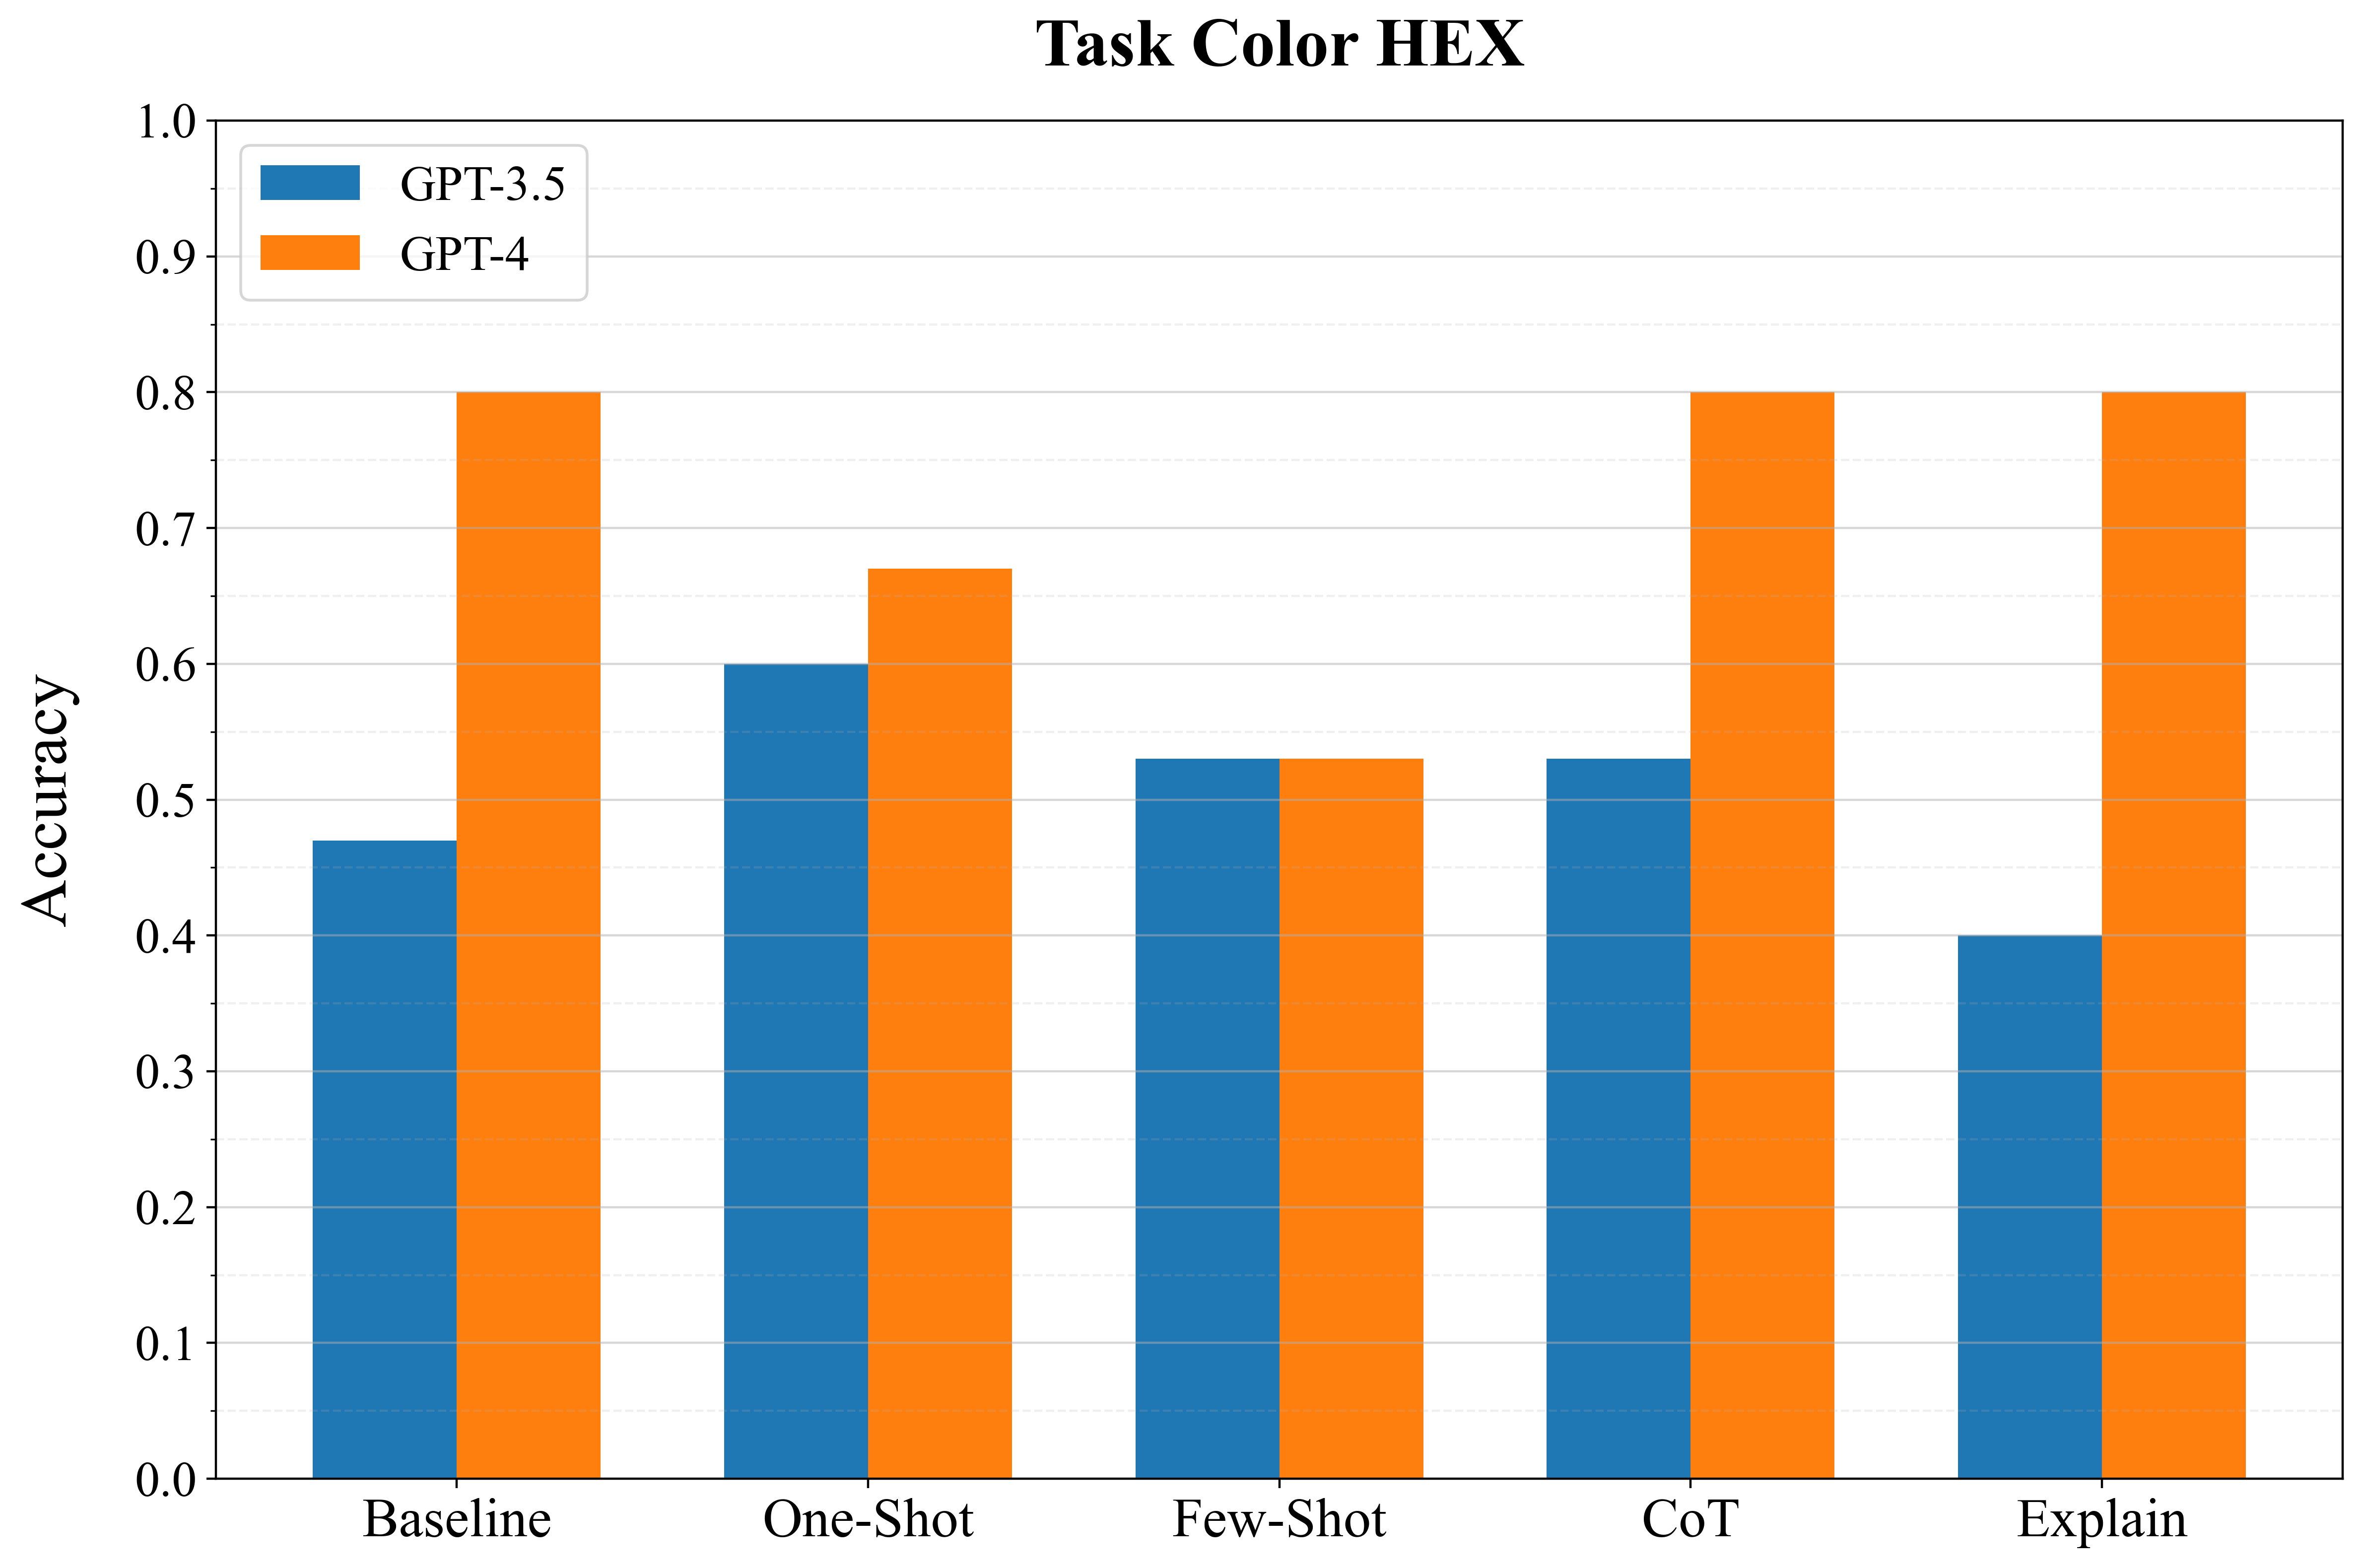

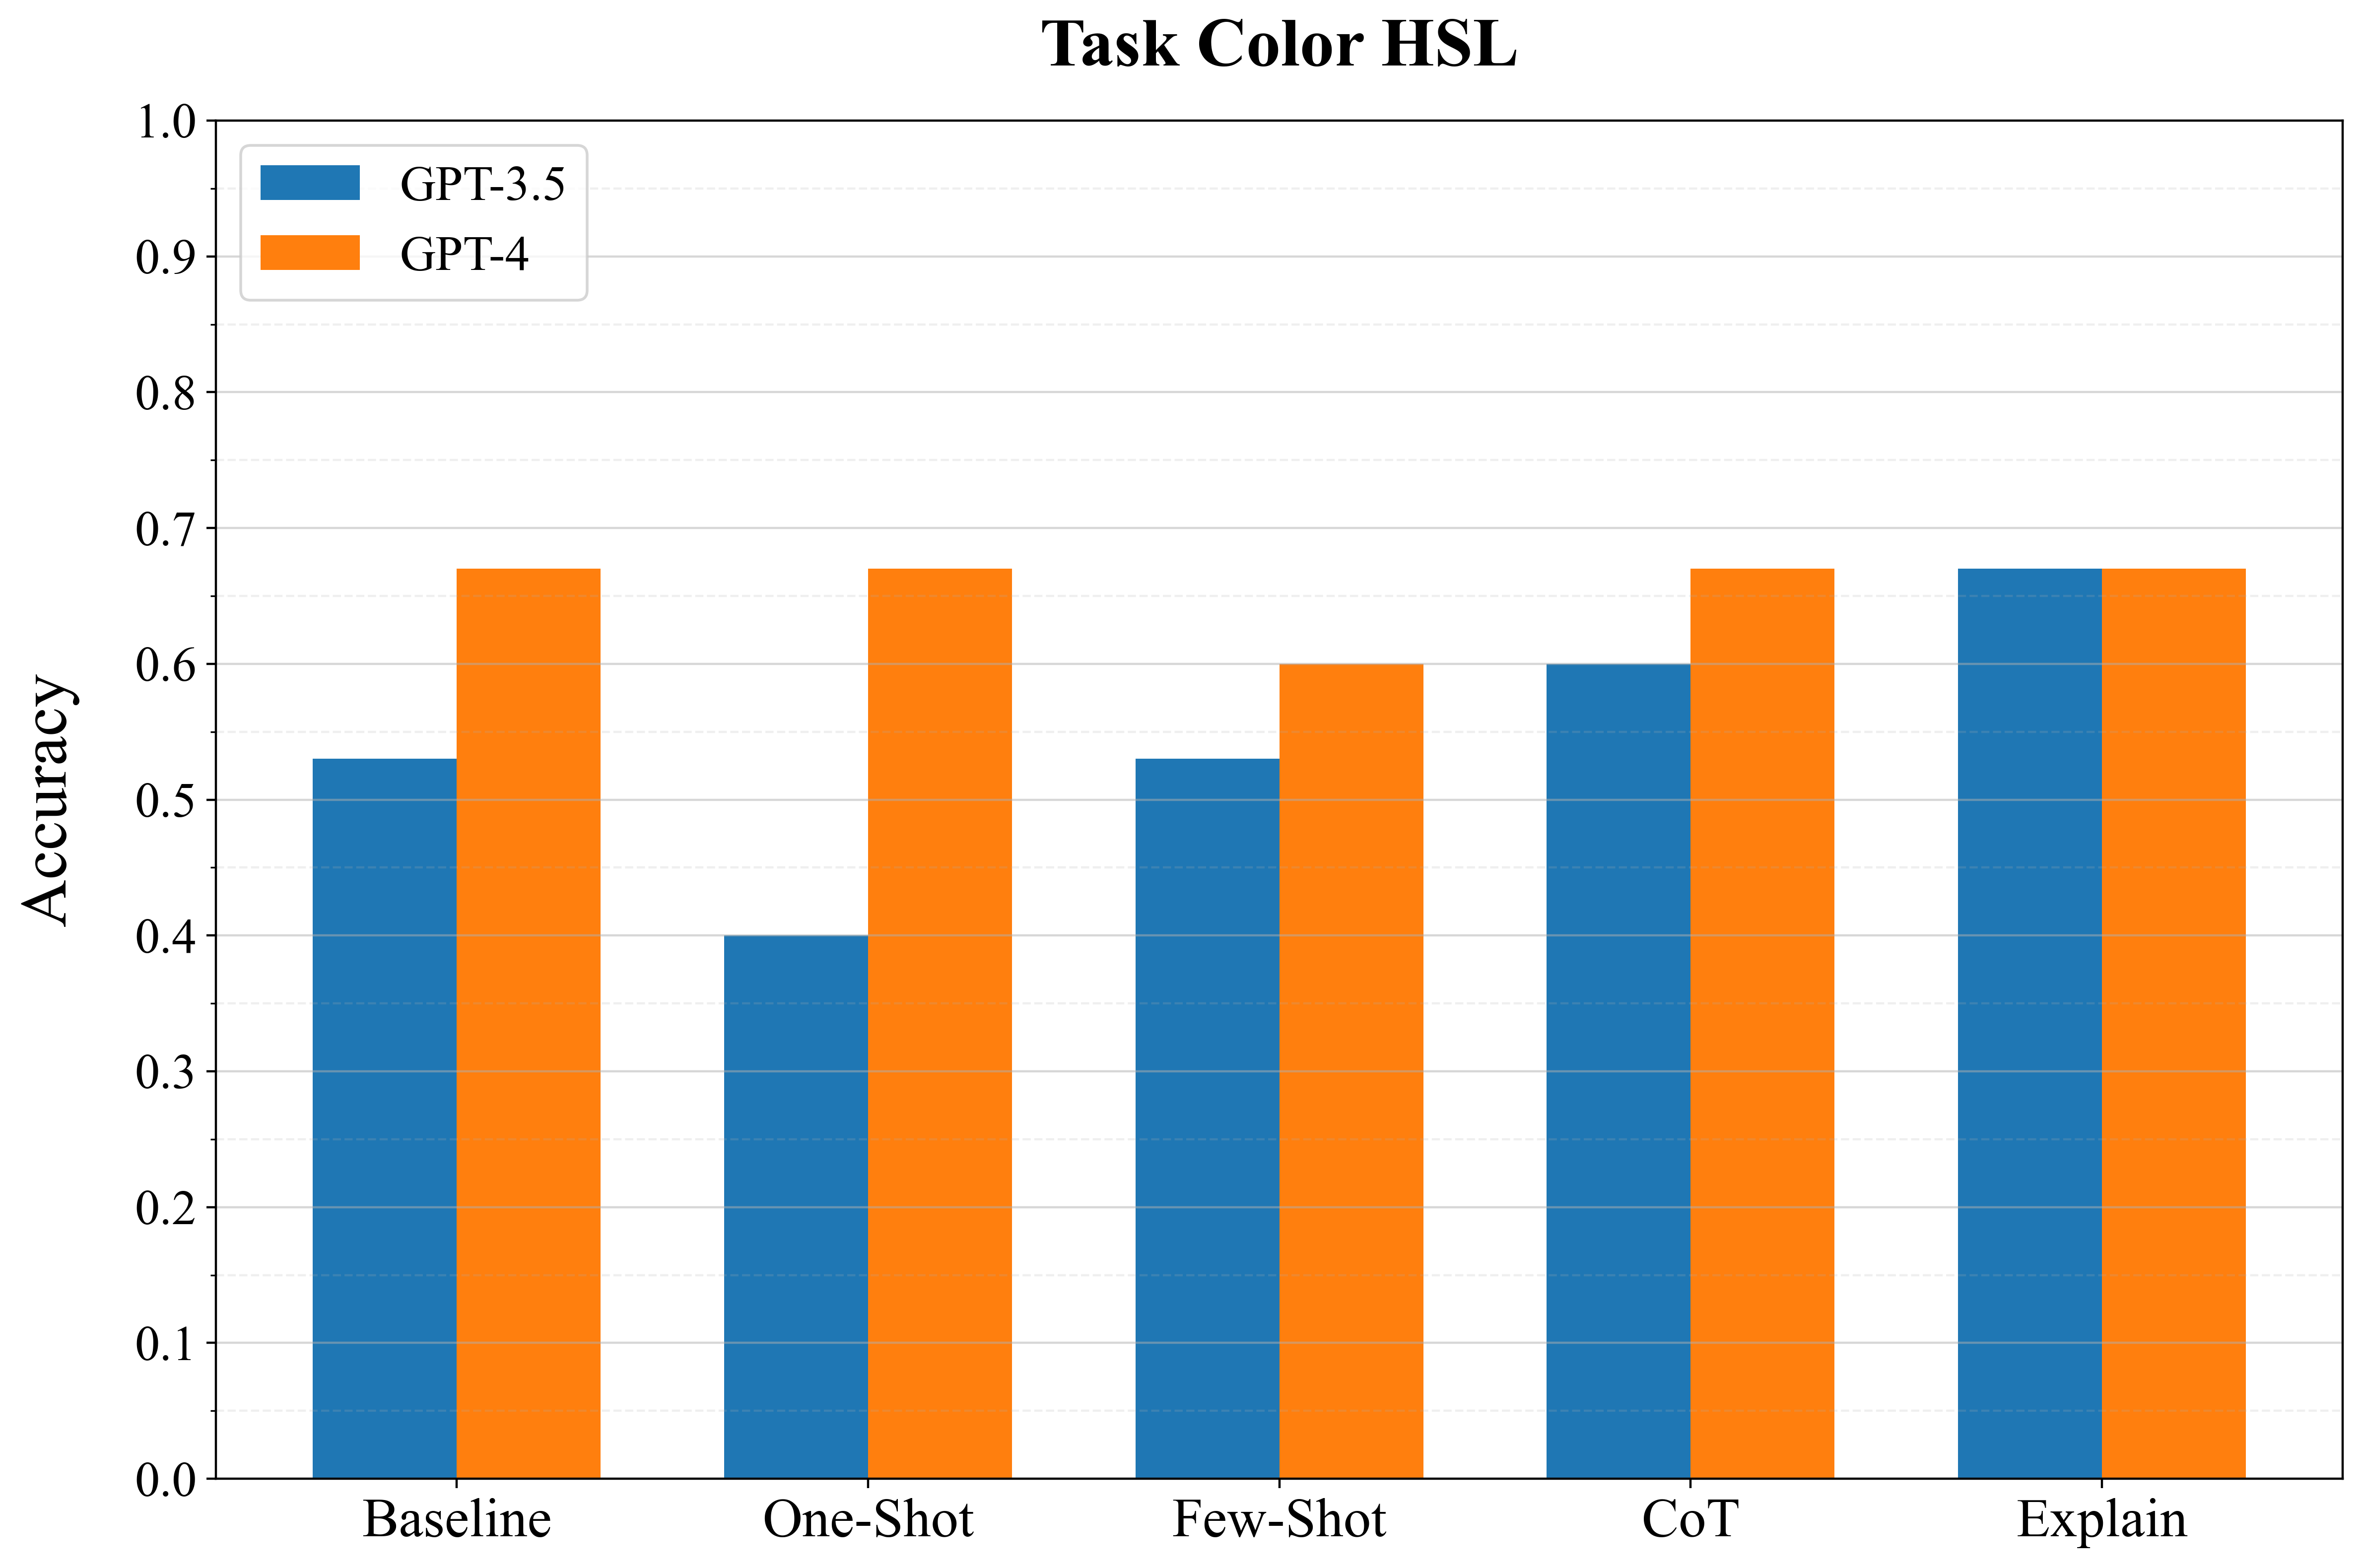

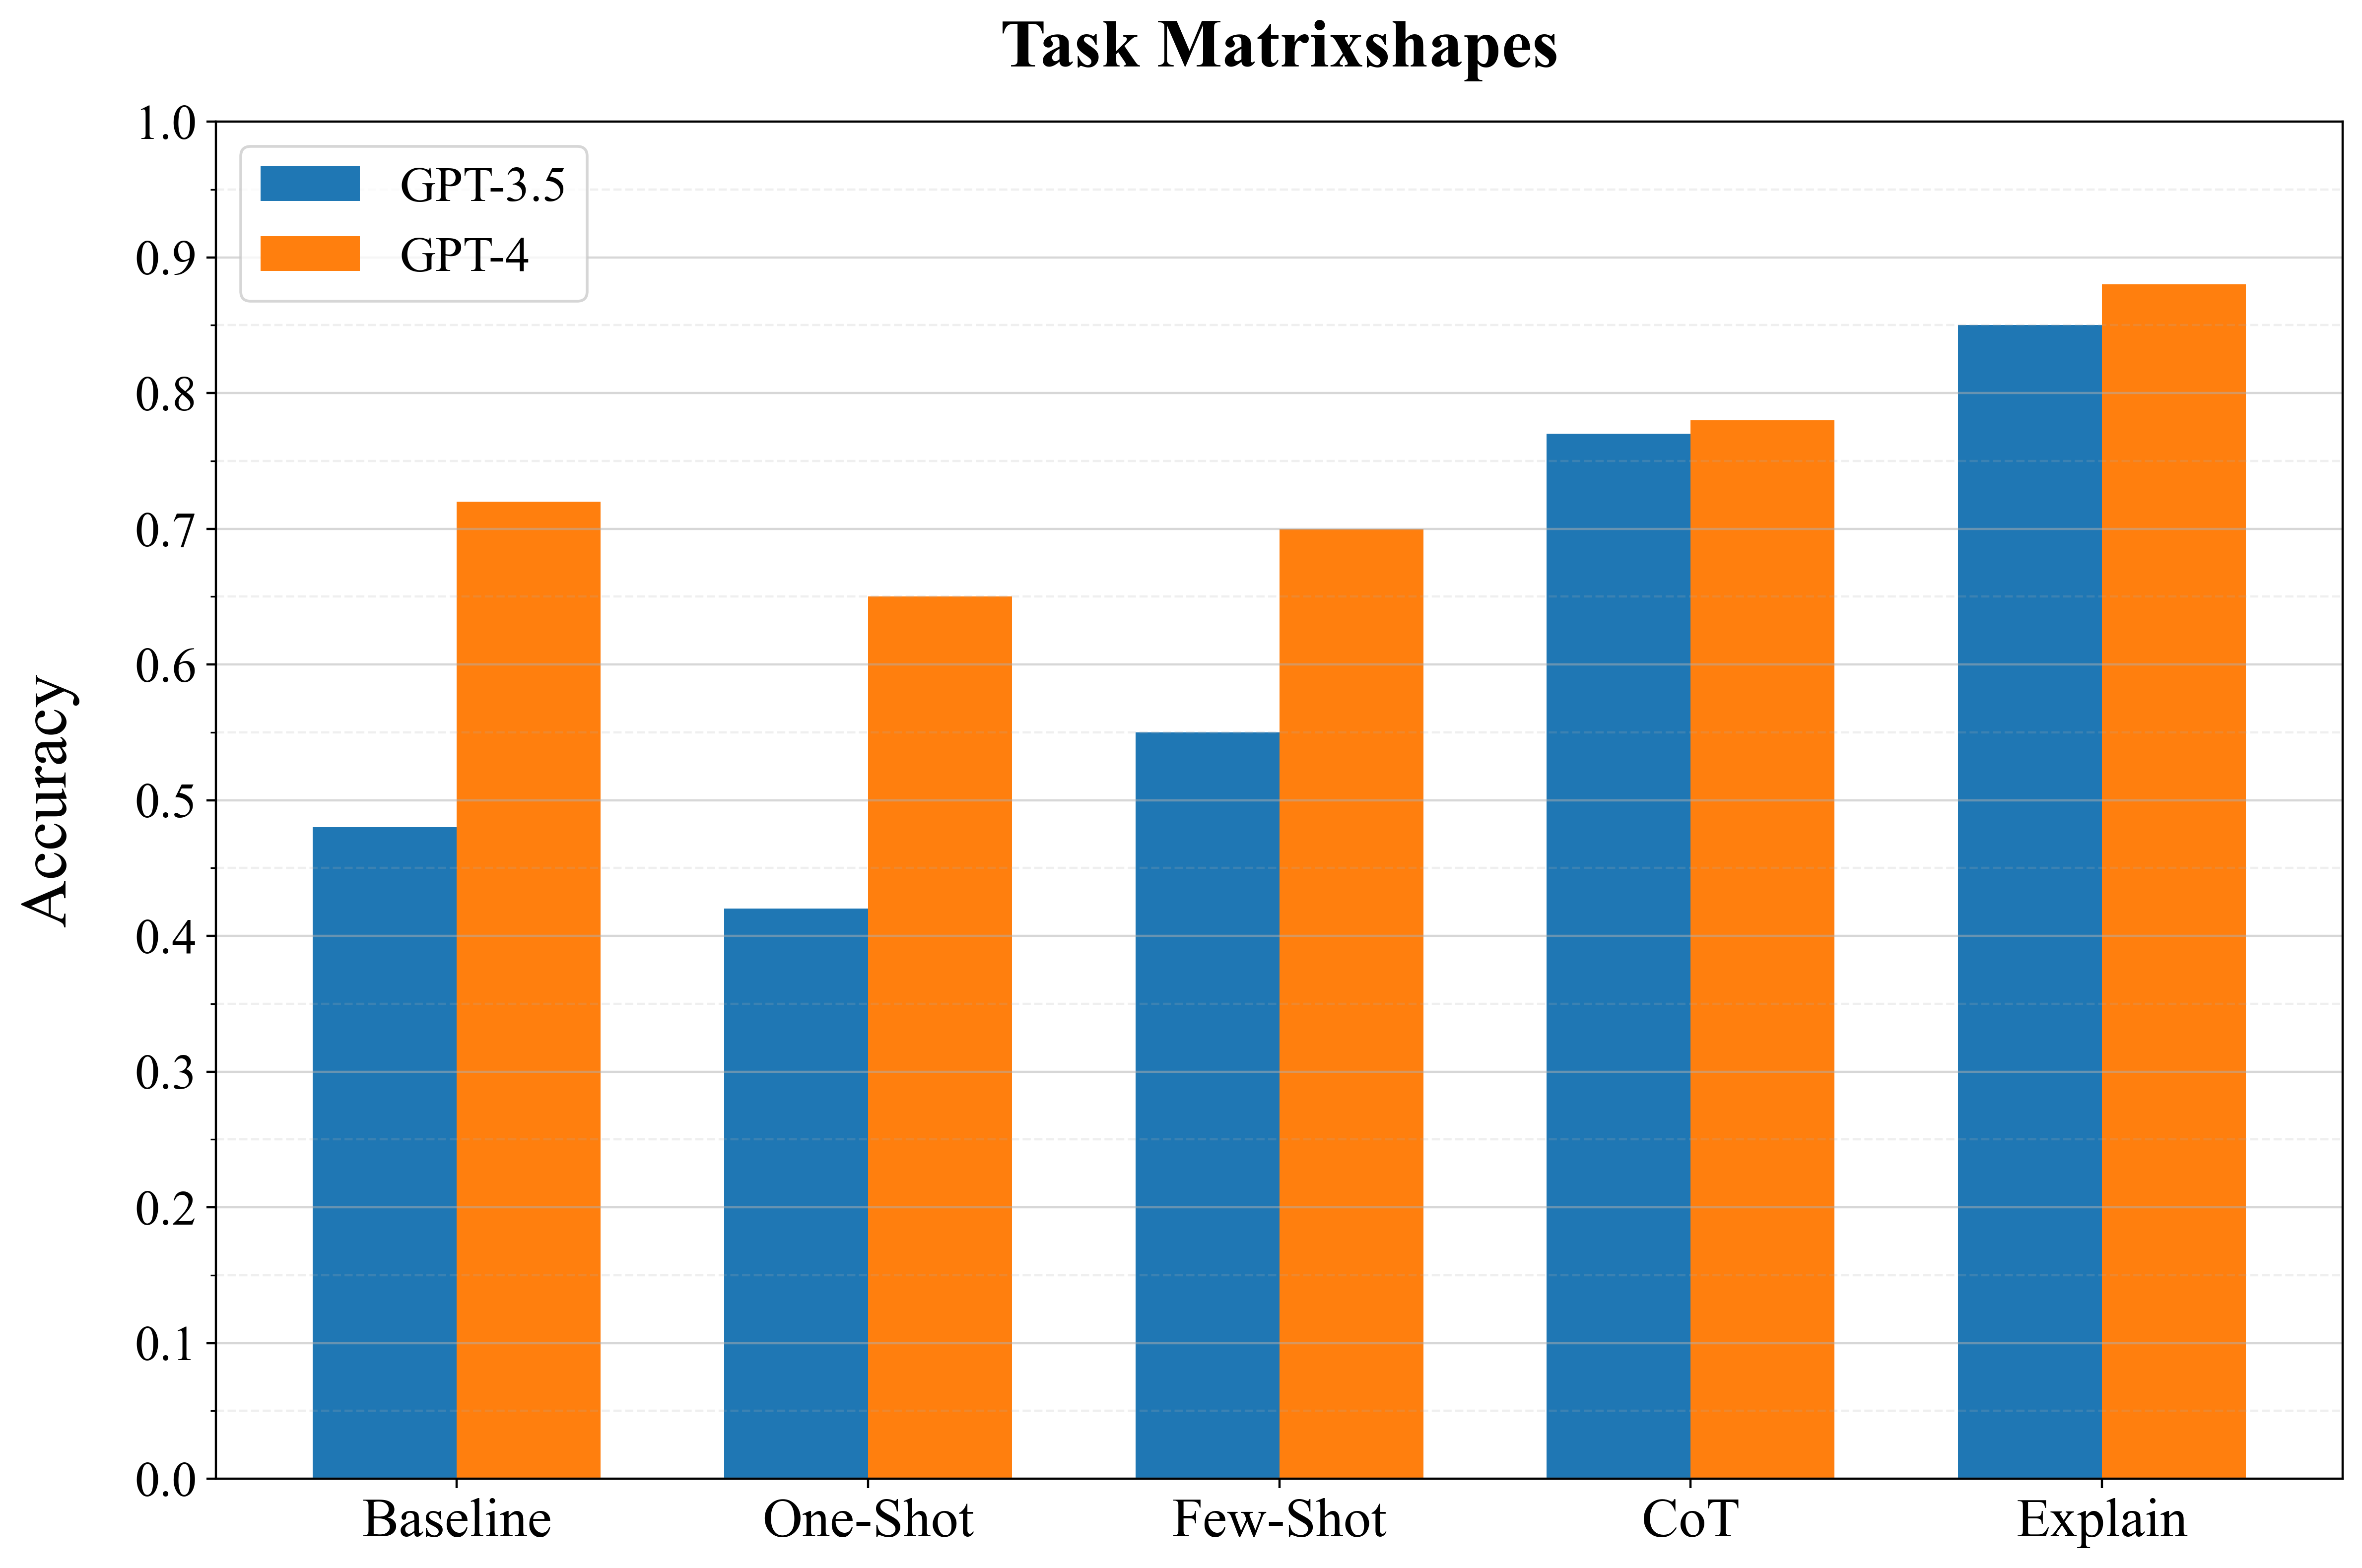

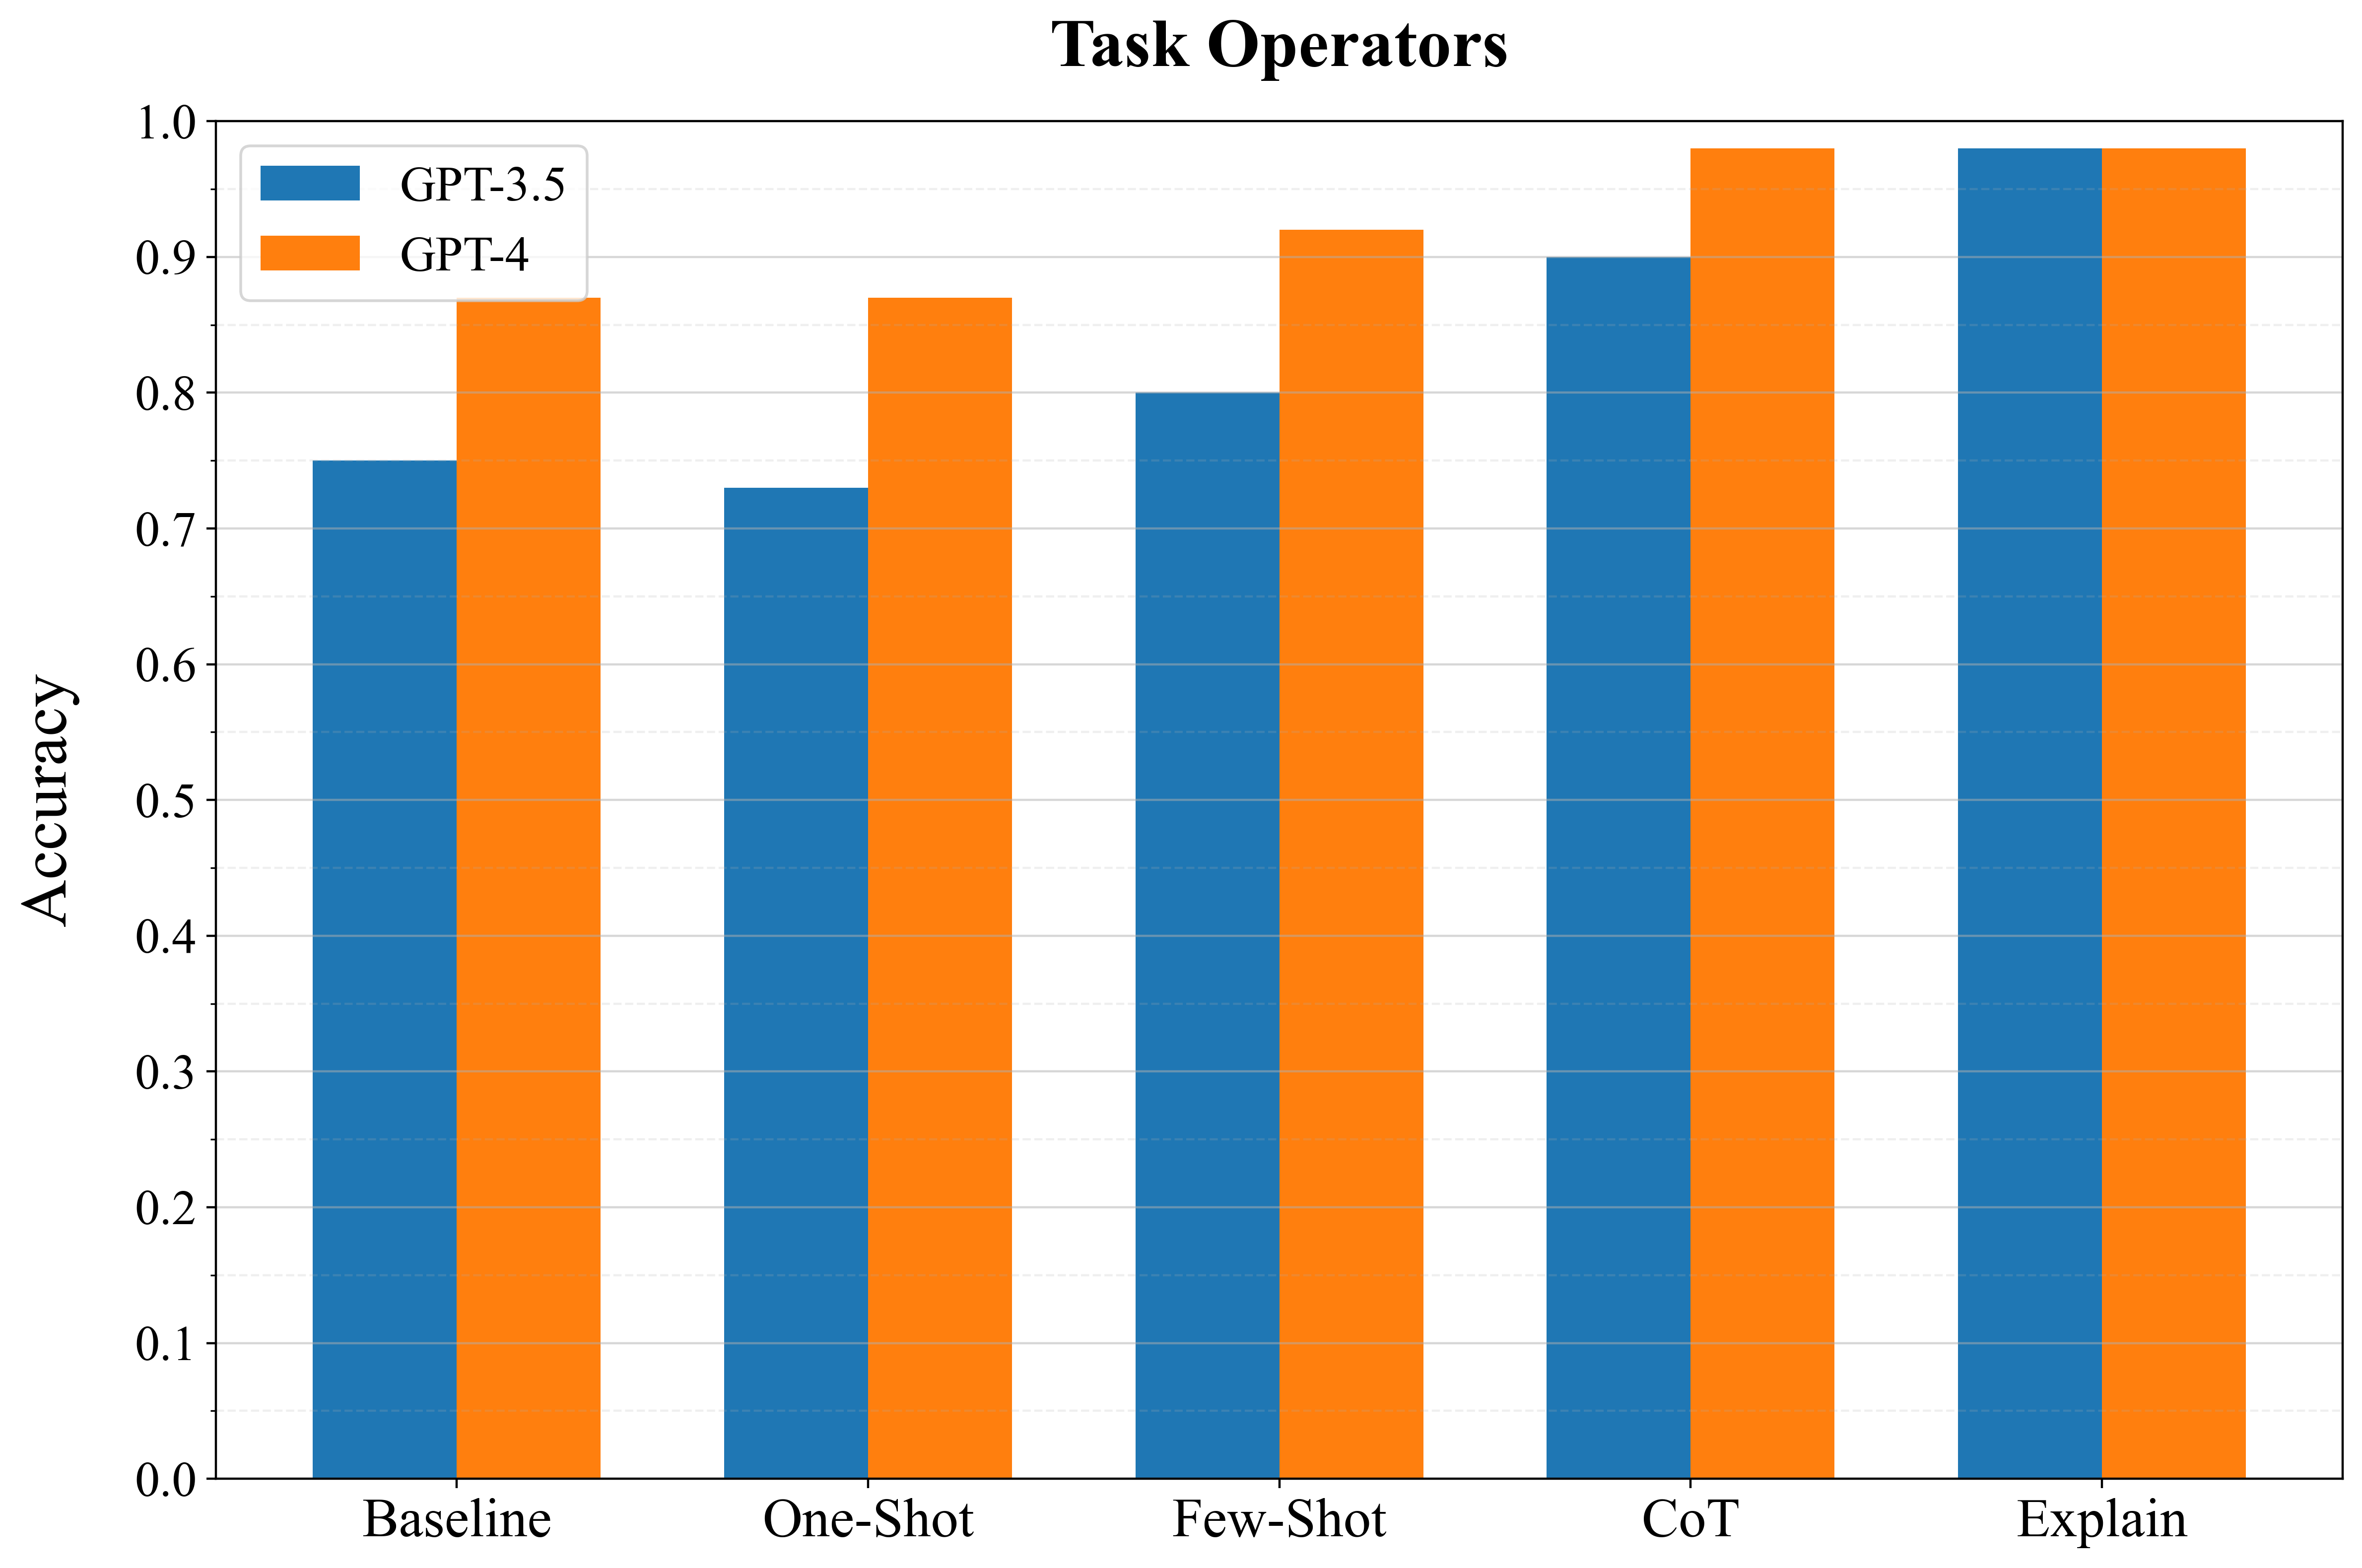

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import wandb

# Initialize the API
api = wandb.Api()

# Specify the project path (in the format "username/project")
project_path = "simone-bresciani/LLMs-Still-Can-t"
runs = api.runs(project_path)

plt.rcParams["font.family"] = "Times New Roman"

# Define your custom order. This could be a list, a dictionary, etc.
custom_order = {'Baseline': 1, 'One-Shot': 2, 'Few-Shot': 3, 'CoT' : 4, 'Explain' : 5}

# Define a function that maps each key to its sort order.
def sort_order(key):
    return custom_order.get(key, 0)  # Default to 0 if the key is not found.


def print_plot(data, title):
    keys = sorted(data.keys(), key=sort_order)
    models = sorted(set(model for values in data.values() for model in values.keys()))

    x = np.arange(len(keys))

    plt.figure(figsize=(12, 8), dpi=400)
    width = 0.35  # Width of the bars
    for i, model in enumerate(models):
        accuracies = [data[key].get(model, 0) for key in keys]
        bars = plt.bar(x - width/2 + i*width, accuracies, width, label=model)
        for bar in bars:
            yval = bar.get_height()
            #plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom' , fontsize=16, color='black')

    plt.title(title, fontsize=25, color='black', fontweight='bold', pad=20)
    plt.ylabel('Accuracy', fontsize=24, color='black', labelpad=20)
    plt.xticks(x,keys, fontsize=20)

    ax = plt.gca()
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_yticks(np.arange(0, 1.1, 0.05), minor=True)
    ax.tick_params(axis='y', labelsize=18)  # Set yticks fontsize
    ax.grid(which='minor', alpha=0.2, axis='y', linestyle='--')
    ax.grid(which='major', alpha=0.5, axis='y')

    plt.ylim(0, 1)
    plt.legend(fontsize=18, loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_task(task):
    data = {}
    for run in [run for run in runs if task.json_string in run.summary['name']]:
        name = run.summary['name'].split(' [')[0].replace('ChainOfThoughts', 'CoT')
        shots = run.summary['shots'] 
        model = '-'.join(run.summary['model'].split('-')[:2]).upper()
        accuracy = run.summary['accuracy']  
        key = name if shots == 0 else ('One-Shot' if shots == 1 else 'Few-Shot')
        if key not in data:
            data[key] = {}
        data[key][model] = accuracy
    print_plot(data, task.json_string.split('/')[1].split('.')[0].replace('_', ' ').title().replace('Hcl', 'HCL').replace('Rgb', 'RGB').replace('Hex', 'HEX').replace('Hsl', 'HSL').replace('Anachronisms', 'Anachronism'))


def plot_color_mean():
    data = {}
    for run in [run for run in runs if 'color' in run.summary['name']]:
        name = run.summary['name'].split('[')[0]
        shots = run.summary['shots'] 
        model = run.summary['model'] 
        sum = 0
        for type in [run for run in runs if 'color' in run.summary['name'] and name in run.summary['name'] and shots == run.summary['shots'] and model == run.summary['model']]:
            sum += type.summary['accuracy']
        accuracy = sum / 4
        key = name if shots == 0 else f'{name}(shots={shots})'
        if key not in data:
            data[key] = {}
        data[key][model] = accuracy
    print_plot(data, 'Color')
    

for task in [anachronism, logical_sequence, color_HCL, color_RGB, color_HEX, color_HSL, matrixshapes, operators]:
    plot_task(task)
#plot_color_mean()


In [ ]:
from matplotlib import font_manager

fonts = set([f.name for f in font_manager.fontManager.ttflist])

for font in sorted(fonts):
    print(font)